In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error

457
455
R²: 0.939
RMSE: 0.530


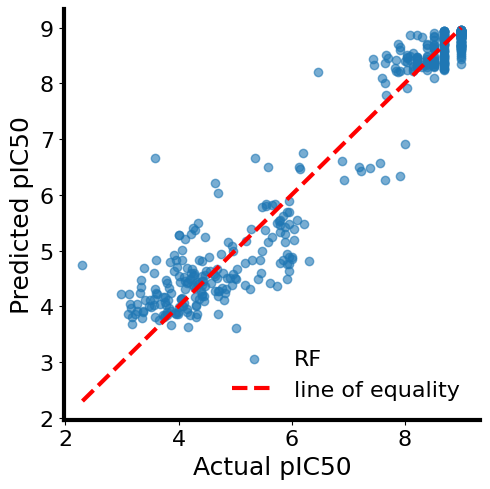

In [2]:

# Global styling settings
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['legend.fontsize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16


def clean_plot(ax, legend=True):
    """Custom function to clean plots."""
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(3)  # Y-axis
    ax.spines['bottom'].set_linewidth(3)  # X-axis
    if legend:
        ax.legend(frameon=False, fontsize=16)


# --- Data Preparation ---
df = pd.read_csv('../Raw Files/G12C_training.csv')
df = df.dropna()

def pIC50(input_df):
    input_df = input_df.copy()
    input_df["IC50 (nM)"] = pd.to_numeric(input_df["IC50 (nM)"], errors='coerce')

    # Replace zeros with a small value (1e-12 nM = 1e-21 M)
    molar = np.where(input_df["IC50 (nM)"] == 0,
                     1e-12 * 1e-9,
                     input_df["IC50 (nM)"] * 1e-9)

    return -np.log10(molar)
# Filter and sample data before splitting
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]


df = df.dropna(subset=['IC50 (nM)'])  # Remove rows with invalid IC50
print(len(df))



df = df[(df['FC'] == 0)] #& (df['IC50 (nM)'] <= 10)]
y = df['IC50 (nM)']


df['pIC50'] = pIC50(df)  # New column
df = df[df['pIC50'] <= 20]
print(len(df))

y = df['pIC50']  # <-- Now using correct column
X = df.drop(columns=["ChEMBL ID", "FC", 'IC50 (nM)', "Smiles", "pIC50"])  # Drop old IC50 and new pIC50


# --- Pipeline with Feature Selection ---
pipe = Pipeline([
    ('variance_threshold', VarianceThreshold(threshold=0.16)),
    ('univariate_select', SelectKBest(score_func=f_regression, k=50)),
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(
        max_depth=20,
        min_samples_leaf=10,
        random_state=42
    ))
])

# --- Cross-Validation & Evaluation ---
cv = KFold(n_splits=15, shuffle=True, random_state=42)
y_pred = cross_val_predict(pipe, X, y, cv=cv)

# Calculate metrics
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

print(f"R²: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")

# --- Plotting with custom styling ---
plt.figure(figsize=(5, 5))

# Scatter plot with transparency
plt.scatter(y, y_pred, alpha=0.6, label='RF')  # Changed label to 'RF' for Random Forest

# Line of equality (perfect prediction)
min_val = min(y.min(), y_pred.min())
max_val = max(y.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='line of equality')

# Labels and title
plt.xlabel("Actual pIC50")
plt.ylabel("Predicted pIC50")

# Apply custom styling
clean_plot(plt.gca())

# Adjust layout and save
plt.subplots_adjust(bottom=0.2)
plt.tight_layout()
plt.savefig("Actual_vs_Predicted_G12C_RF.png", dpi=300)
plt.show()